In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://docs.quantum-computing.ibm.com/run/primitives
# result = Sampler().run(circuits).result()

ModuleNotFoundError: No module named 'ibm_quantum_widgets'

In [2]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import U3Gate
from qiskit.extensions import UnitaryGate
# Important packages:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import execute, Aer
import numpy as np
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import random_unitary
from qiskit.extensions import UnitaryGate

In [3]:
def decimalToBinary(n,N):
    bin1=bin(n).replace("0b", "")
    bin2='0'*(N-len(bin1))+bin1
    return bin2

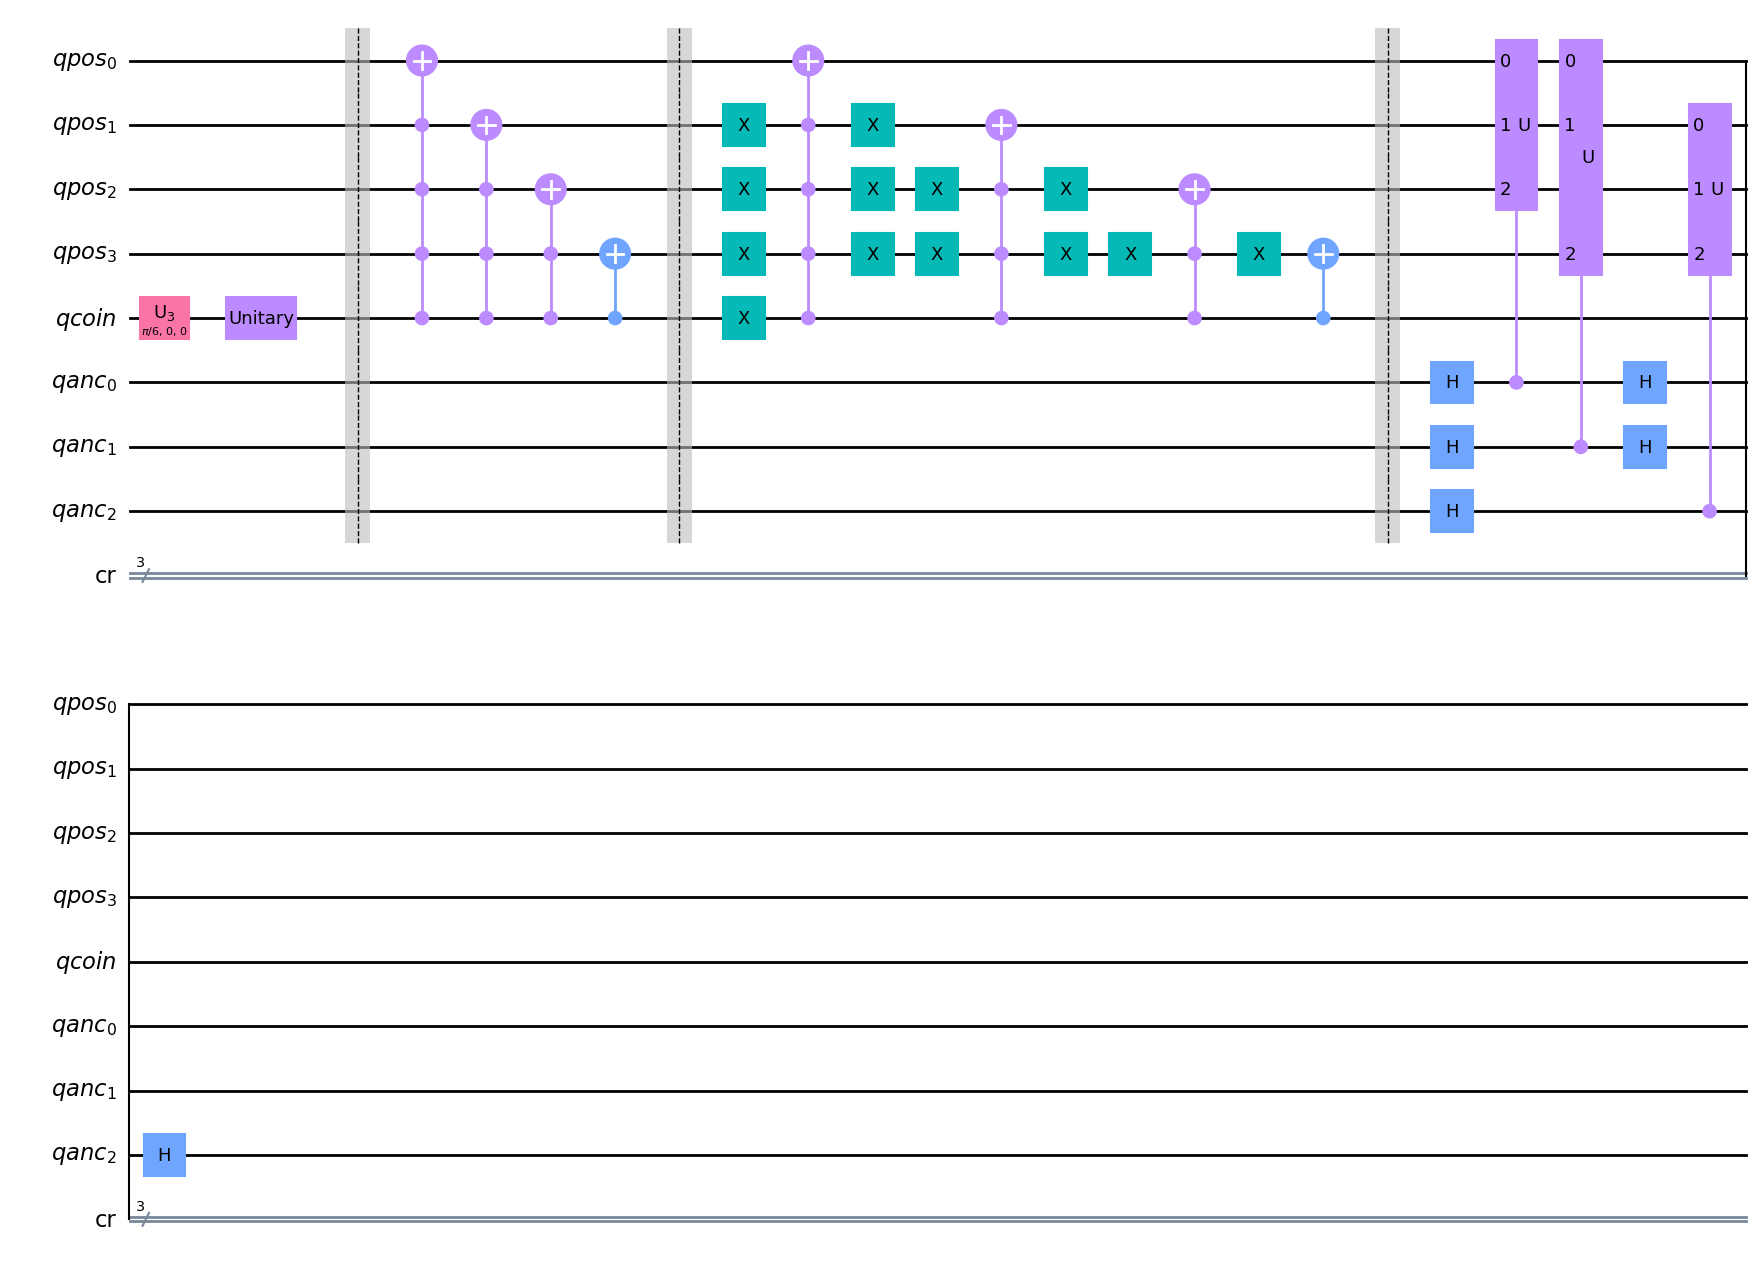

In [4]:
# Define the message and ensure it has an even number of bits
original_message = "00110011010101010101010011000111"
if len(original_message) % 2 != 0:
    original_message += "0"
    
steps = 2  # Number of steps, corresponding to the length of the message
n = 4  # Number of quantum positions

qanc = QuantumRegister(3, 'qanc')
qpos = QuantumRegister(n, 'qpos')
qcoin = QuantumRegister(1, 'qcoin')
cpos = ClassicalRegister(3, 'cr')
circuit = QuantumCircuit(qpos, qcoin, cpos, qanc)
    

initial_angle = np.arcsin(np.sin(np.pi/6))  # Adjust the angle θ as needed
initial_state = U3Gate(initial_angle, 0, 0)
circuit.append(initial_state, [qcoin])


# Define the coin operators based on the description
def coin_operator_C1():
    return np.array([[np.cos(np.pi/8), np.sin(np.pi/8)],
                     [np.sin(np.pi/8), -np.cos(np.pi/8)]])

def coin_operator_C2():
    return np.array([[np.cos(np.pi/4), np.sin(np.pi/4)],
                     [np.sin(np.pi/4), -np.cos(np.pi/4)]])

def coin_operator_C3():
    return np.array([[np.cos(np.pi/3), np.sin(np.pi/3)],
                     [np.sin(np.pi/3), -np.cos(np.pi/3)]])

def coin_operator_C4():
    return np.array([[np.cos(3*np.pi/7), np.sin(3*np.pi/7)],
                     [np.sin(3*np.pi/7), -np.cos(3*np.pi/7)]])

def apply_coin_operator(circuit, qcoin, message_bits):
    if message_bits == "00":
        circuit.unitary(coin_operator_C1(), [qcoin])
    elif message_bits == "01":
        circuit.unitary(coin_operator_C2(), [qcoin])
    elif message_bits == "10":
        circuit.unitary(coin_operator_C3(), [qcoin])
    elif message_bits == "11":
        circuit.unitary(coin_operator_C4(), [qcoin])

def counts_to_prob_1d(counts, n):
    # Convert histogram counts to probability vector of size 1 x 2^n
    states = list(counts.keys())
    state_counts = list(counts.values())
    nshots = sum(state_counts)
    
    # Create array of probability values in reverse order
    probabilities = np.zeros(2 ** n)
    for i, state in enumerate(states):
        index = int(state, 2)
        probabilities[index] = state_counts[i]
    
    probabilities /= nshots
    return probabilities




def increment_gate(circuit, qpos, qcoin):
    n = len(qpos)
    for i in range(n):
        circuit.mcx([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')

def decrement_gate(circuit, qpos, qcoin):
    n = len(qpos)
    circuit.x(qcoin[0])
    for i in range(n):
        if i + 1 < n:
            circuit.x(qpos[i + 1:])
        circuit.mcx([qcoin[0]] + qpos[i + 1:], qpos[i], None, mode='noancilla')
        if i + 1 < n:
            circuit.x(qpos[i + 1:])

def step(circuit, qpos, qcoin, message_bits):
    apply_coin_operator(circuit, qcoin, message_bits)
    circuit.barrier()
    increment_gate(circuit, qpos, qcoin)
    circuit.barrier()
    decrement_gate(circuit, qpos, qcoin)
    circuit.barrier()
    
def build_circ(_circuit, _register, _params, _n_qubits, _barrier = False):
    """
    Implements a parametrized quantum circuit in the _register chosen.
    """
    for index in range(_n_qubits):
        _circuit.h(index)
        _circuit.rx(_params[index], _register[index])

    # the CNOT Layer
    for k in range(_n_qubits - 1):
        _circuit.cx(_register[k], _register[k+1])

    if _barrier:
        _circuit.barrier()

    return _circuit
 
nqubits = 3
nb_params = nqubits

q = QuantumRegister(nqubits, 'qubit')
circ_psi = QuantumCircuit(q)
p = QuantumRegister(3, 'qubit')
nb_params = 3
circ_phi = QuantumCircuit(p)

params_phi = [el for el in range( nb_params, 2*nb_params)]

circ_phi = build_circ(circ_phi, q, params_phi, 3, _barrier = False)
    
U_phi_dagger = circ_phi.to_gate(label = "U_phi^dagger").inverse()
definition = [q[index] for index in range(nqubits)]
U_circ = circ_psi.copy()
U_circ.append(U_phi_dagger, definition)

      
U_controlled_gate = (U_circ.to_gate(label = "U")).control(1)
definition1 = [qanc[0]] + [qpos[0], qpos[1], qpos[2]]
definition2 = [qanc[1]] + [qpos[0], qpos[1], qpos[3]]
definition3 = [qanc[2]] + [qpos[1], qpos[2], qpos[3]]
evaluate_complex_part = False
    
def run_quantum_coin_walk(message, steps):
    simulator = Aer.get_backend('statevector_simulator')

    for i in range(len(message) // 2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
        
    for i in range(3):
        circuit.h(qanc[i])
        
    # Apply controlled unitary matrix operations
    circuit.append(U_controlled_gate, definition1)
    circuit.append(U_controlled_gate, definition2)
    circuit.append(U_controlled_gate, definition3)
    
   
    for i in range(3):
        circuit.h(qanc[i])
        
       # Measure qanc into cpos
    #circuit.measure(qanc, cpos)

    #job = execute(circuit, simulator, shots=1000)
    #result = job.result()
    #counts = result.get_counts(circuit)
    return circuit

circ=run_quantum_coin_walk('11', 1)
circ.draw('mpl')



In [12]:
from skrmt.ensemble.circular_ensemble import CircularEnsemble
import numpy as np
import random

# Define parameters
n = 6
steps = 2
lqpos = 5
lqcoin = 1
lqanc = 6

# Generate random unitary matrices from the Gaussian Ensemble
list_unitary = [CircularEnsemble(beta=2, n = 4).matrix for _ in range(lqanc)]
for i, matrix in enumerate(list_unitary):
    if not np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T):
        print(f"Matrix {i} is not unitary!")
# Randomize target_qubit
target_qubit = [random.choice(range(0, lqpos)) for _ in range(n)]

In [23]:
original_message1='01100010110101001'
original_message2='11100010110101001'
original_message3='00100010110101001'
original_message4='1100010110101001'
original_message5='011000101101010010'


def circ_quantum_hash(message, steps):
    
    qpos = QuantumRegister(lqpos, 'qpos')
    qcoin = QuantumRegister(1, 'qcoin')
    qanc = QuantumRegister (lqanc, 'qanc')
    cpos = ClassicalRegister(lqanc, 'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos, qanc)
    
    initial_angle = np.arcsin(np.sin(np.pi/6))  # Adjust the angle θ as needed
    initial_state = U3Gate(initial_angle, 0, 0)
    circuit.append(initial_state, [qcoin])
    
    
    for i in range(len(message) // 2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
        
    for i in range(len(qanc)):
        circuit.h(qanc[i])
        
        haar_random_gate = UnitaryGate(list_unitary[i]) #Applying a single qubit random unitary gate
        qc = QuantumCircuit(1)
        qc.append(haar_random_gate, [0])

        custom = qc.to_gate().control(1) #adding a single control to it

        
        circuit.append(custom, [lqpos+lqcoin+i, target_qubit[i]])

        circuit.h(qanc[i])
        
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    psi_block2 = job.result().get_statevector(circuit, decimals=16)
    list1=[]
    list2=[]
    for j in range(len(psi_block2)):        
        list1.append(j)
        list2.append(abs(psi_block2[j]))

    nv= lqpos+lqanc+lqcoin
    probave2=list(abs(num**2) for num in list2)
    states = [decimalToBinary(i, nv) for i in range(2**nv)]
    possible_hash=[decimalToBinary(i, lqanc) for i in range(2**lqanc)]
    counts = dict(zip(states, probave2))
    hash_prob_list=[]
    for j in possible_hash:
        hash_prob=0.0
        for i in states:
            hash_state=i[lqcoin+lqpos:]
            if j==hash_state:
                hash_prob+=counts[i]
        hash_prob_list.append(hash_prob)
    
    hash_counts=dict(zip(possible_hash, hash_prob_list))
    hash_counts
    return hash_counts

def generate_hash_from_counts(hash_counts):
    # Concatenate the binary hash values corresponding to sorted hash counts
    sorted_counts = dict(sorted(hash_counts.items(), key=lambda item: item[1], reverse=True))
    hash_value = ''.join(sorted_counts.keys())
    print(hash_value)
    return hash_value



count=circ_quantum_hash(original_message1, n)
generate_hash_from_counts(count)
count=circ_quantum_hash(original_message2, n)
generate_hash_from_counts(count)
count=circ_quantum_hash(original_message3, n)
generate_hash_from_counts(count)
count=circ_quantum_hash(original_message4, n)
generate_hash_from_counts(count)
count=circ_quantum_hash(original_message5, n)
generate_hash_from_counts(count)

CircuitError: 'The amount of qubit(1)/clbit(0) arguments does not match the gate expectation (2).'

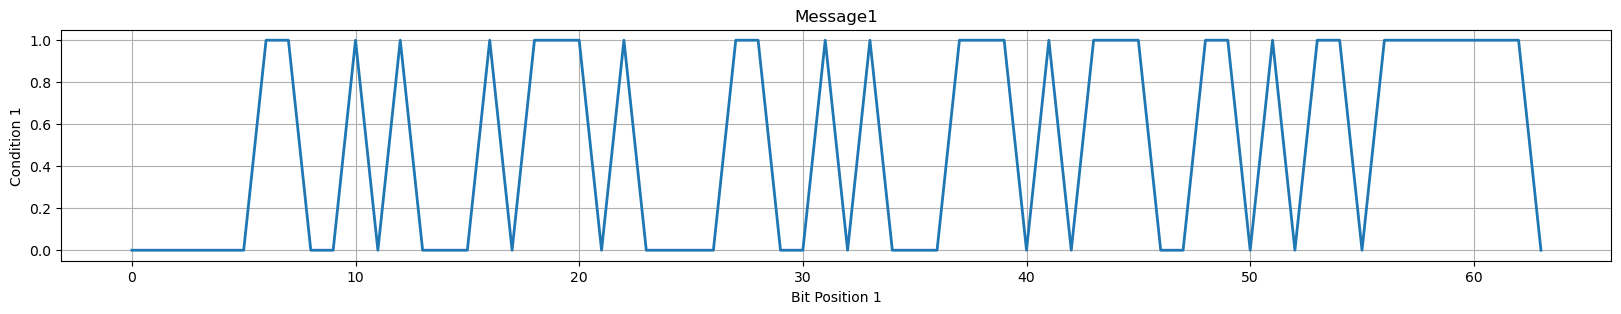

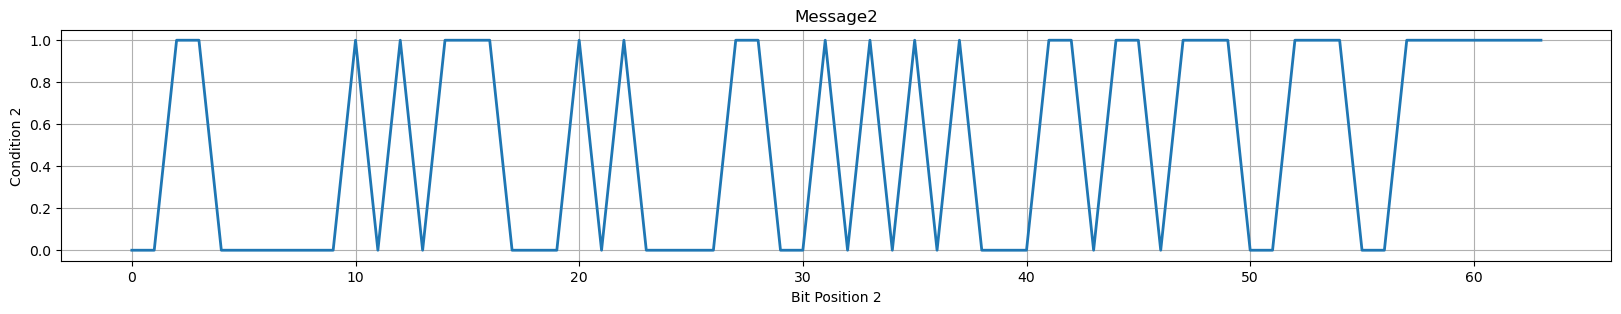

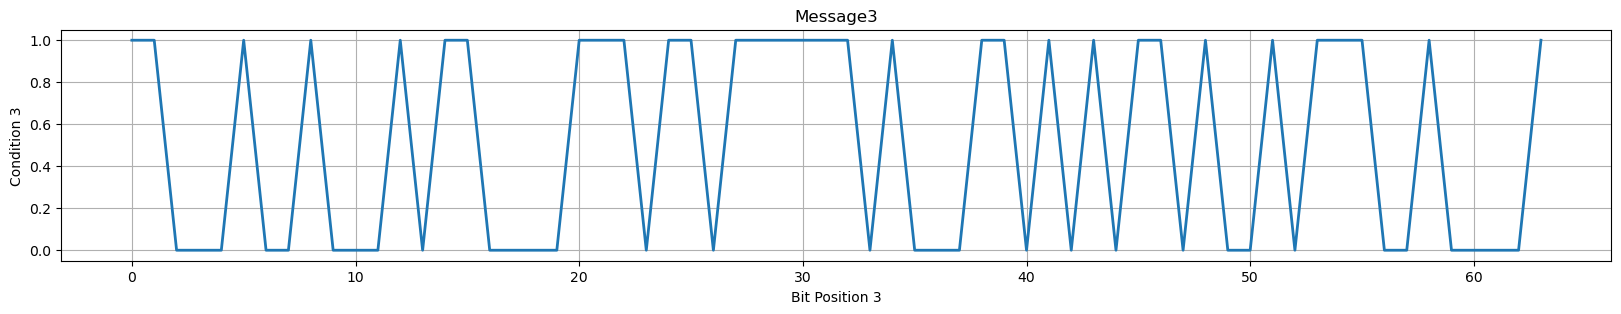

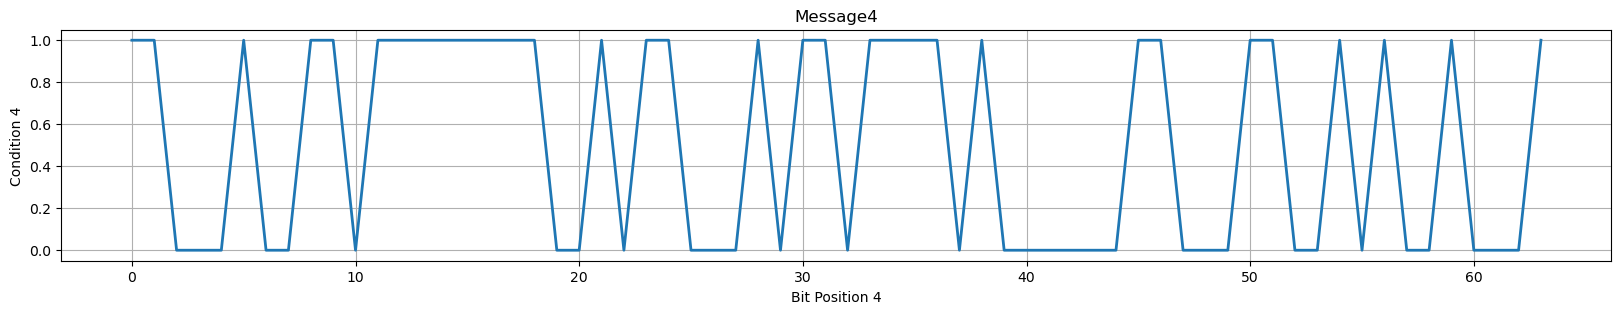

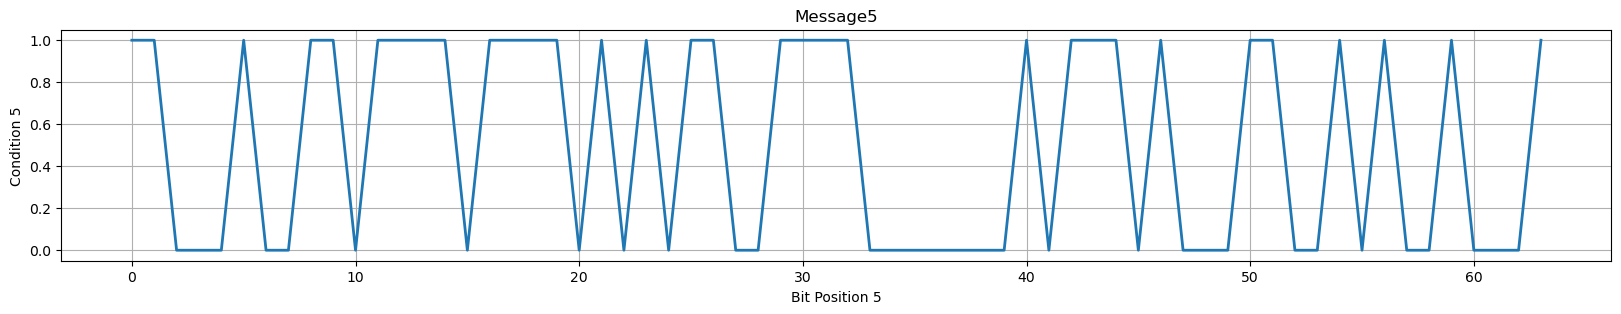

In [61]:


import matplotlib.pyplot as plt

# Define the binary messages
binary_strings = [
    "0000001100101000101110100001100101000111010111001101011011111110",
    "0011000000101011100010100001100101010100011011011100111001111111",
    "1100010010001011000011101101111110100011010101101001011100100001",
    "1100010011011111111001011000101101111010000001100011001010010001",
    "1100010011011110111101010110011110000000101110100011001010010001"
]

# Plot each binary string separately
for idx, binary_string in enumerate(binary_strings, start=1):
    # Convert binary string to list of integers
    binary_list = [int(bit) for bit in binary_string]

    # Create x-values representing the position of each bit
    x_values = range(len(binary_list))

    # Create y-values from the binary list
    y_values = binary_list

    # Plot the graph
    plt.figure(figsize=(20, 3))
    plt.plot(x_values, y_values, linewidth=2)
    plt.xlabel(f'Bit Position {idx}')
    plt.ylabel(f'Condition {idx}')
    plt.title(f'Message{idx}')
    plt.grid(True)
    plt.show()


In [9]:
# Define the binary messages
binary_strings = [
    "000000001100000100001000000001001101000101001001100111101011100011000111001011001111000011101111100000100110100100101010100010001010000110000010001110010000101110011100010100011000100001101000101100100101010001011101010101011001110111101001101101111011110011010111011011011111010011111111110000110110110100111010110010011010010110010010011110111110110001111000111100110101111001111101",
    "001100000000001000000100001101100100000001001001100000000101101100101000100101100001011100101101010000011000101001101111101011001111001011010100011101110100010001011001110000001010101110101010001110010101100111000111000011100011111100111000110101110001100110000010000110100010111101111001111111111011011111011011011010111110111010011110110111010111010011110011110110010010010110110010",
    "100111101011100011000000000100000111101111000011001100001000001011100110101010001111100010000001000101000110101110000010001101001001001010001110110111100000111011110011101100010000100100010100101000010111111111010011011100011000011011110110100001111010011111110010101101010001100101010101101001010110111110010010011101011001011010011110110000111100110100111000110001111101110101111001",
    "001100001000000000001101001001000100000001100000100100100011000101100111001011001111100001100101011100101000101100011000100010100110101011101111001110001010010000011101101001101101011001010100000111101010000011101110010001110000110100000010110011010101000110110111011011011111110001110101111000111100110010110110111011111111011110011010111001111101010111111010010011111110010010010110",
    "111111010000011100111011010100011000111110010001011101111010010101011001110011110111011011011111110010110110101111111100000000001100101011111000000100011010001000110000011110110100101110010011111001000001010111001101111101101010000101001001110001110101100011100111010010010110001011001111100010100110101100101000001010100000001110100100000011101001000111101101100001100101000010000110"
]

# Plot each binary string separately
for idx, binary_string in enumerate(binary_strings, start=1):
    # Convert binary string to hexadecimal
    hex_string = hex(int(binary_string, 2))
    
    # Format the hexadecimal string to the requested format
    formatted_hex_string = ' '.join([f"'{hex_digit.upper()}'" for hex_digit in hex_string[2:]])

    # Print the formatted hexadecimal representation
    print(f"Condition{idx}: {formatted_hex_string}")


Condition1: 'C' '1' '0' '8' '0' '4' 'D' '1' '4' '9' '9' 'E' 'B' '8' 'C' '7' '2' 'C' 'F' '0' 'E' 'F' '8' '2' '6' '9' '2' 'A' '8' '8' 'A' '1' '8' '2' '3' '9' '0' 'B' '9' 'C' '5' '1' '8' '8' '6' '8' 'B' '2' '5' '4' '5' 'D' '5' '5' '9' 'D' 'E' '9' 'B' '7' 'B' 'C' 'D' '7' '6' 'D' 'F' '4' 'F' 'F' 'C' '3' '6' 'D' '3' 'A' 'C' '9' 'A' '5' '9' '2' '7' 'B' 'E' 'C' '7' '8' 'F' '3' '5' 'E' '7' 'D'
Condition2: '3' '0' '0' '2' '0' '4' '3' '6' '4' '0' '4' '9' '8' '0' '5' 'B' '2' '8' '9' '6' '1' '7' '2' 'D' '4' '1' '8' 'A' '6' 'F' 'A' 'C' 'F' '2' 'D' '4' '7' '7' '4' '4' '5' '9' 'C' '0' 'A' 'B' 'A' 'A' '3' '9' '5' '9' 'C' '7' '0' 'E' '3' 'F' '3' '8' 'D' '7' '1' '9' '8' '2' '1' 'A' '2' 'F' '7' '9' 'F' 'F' 'B' '7' 'D' 'B' '6' 'B' 'E' 'E' '9' 'E' 'D' 'D' '7' '4' 'F' '3' 'D' '9' '2' '5' 'B' '2'
Condition3: '9' 'E' 'B' '8' 'C' '0' '1' '0' '7' 'B' 'C' '3' '3' '0' '8' '2' 'E' '6' 'A' '8' 'F' '8' '8' '1' '1' '4' '6' 'B' '8' '2' '3' '4' '9' '2' '8' 'E' 'D' 'E' '0' 'E' 'F' '3' 'B' '1' '0' '9' '1' '4' 'A' '1' '7' 

In [12]:
original_message='1111111111'
from skrmt.ensemble.circular_ensemble import CircularEnsemble
import numpy as np
import random

# Define parameters
n = 5
steps = 2
lqpos = 5
lqcoin = 1
lqanc = 5

# Generate random unitary matrices from the Gaussian Ensemble
list_unitary = [CircularEnsemble(beta=1, n = 8).matrix for _ in range(lqanc)]
for i, matrix in enumerate(list_unitary):
    if not np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T):
        print(f"Matrix {i} is not unitary!")
# Randomize target_qubit
target_qubit = [random.choice(range(0, lqpos)) for _ in range(n)]

In [13]:
import collections

def circ_quantum_hash(message, steps):
    
    qpos = QuantumRegister(lqpos, 'qpos')
    qcoin = QuantumRegister(1, 'qcoin')
    qanc = QuantumRegister (lqanc, 'qanc')
    cpos = ClassicalRegister(lqanc, 'cr')
    circuit = QuantumCircuit(qpos, qcoin, cpos, qanc)
    
    initial_angle = np.arcsin(np.sin(np.pi/6))  # Adjust the angle θ as needed
    initial_state = U3Gate(initial_angle, 0, 0)
    circuit.append(initial_state, [qcoin])
    
    
    for i in range(len(message) // 2):
        message_bits = message[i * 2:i * 2 + 2]  # Extract the message bits for this step
        step(circuit, qpos, qcoin, message_bits)
        
    for i in range(len(qanc)):
        circuit.h(qanc[i])
        
        haar_random_gate = UnitaryGate(list_unitary[i]) #Applying a single qubit random unitary gate
        qc = QuantumCircuit(3)
        qc.append(haar_random_gate, [0,1,2])

        custom = qc.to_gate().control(1) #adding a single control to it

        
        circuit.append(custom, [lqpos+lqcoin+i, target_qubit[i], (target_qubit[i]+1)%n, (target_qubit[i]+2)%n])

        circuit.h(qanc[i])
        
    backend = Aer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    psi_block2 = job.result().get_statevector(circuit, decimals=16)
    list1=[]
    list2=[]
    for j in range(len(psi_block2)):        
        list1.append(j)
        list2.append(abs(psi_block2[j]))

    nv= lqpos+lqanc+lqcoin
    probave2=list(abs(num**2) for num in list2)
    states = [decimalToBinary(i, nv) for i in range(2**nv)]
    possible_hash=[decimalToBinary(i, lqanc) for i in range(2**lqanc)]
    counts = dict(zip(states, probave2))
    hash_prob_list=[]
    for j in possible_hash:
        hash_prob=0.0
        for i in states:
            hash_state=i[lqcoin+lqpos:]
            if j==hash_state:
                hash_prob+=counts[i]
        hash_prob_list.append(hash_prob)
    
    hash_counts=dict(zip(possible_hash, hash_prob_list))
    hash_counts
    return hash_counts

def generate_hash_from_counts(hash_counts):
    # Concatenate the binary hash values corresponding to sorted hash counts
    sorted_counts = dict(sorted(hash_counts.items(), key=lambda item: item[1], reverse=True))
    hash_value = ''.join(sorted_counts.keys())
    return hash_value

def calculate_changed_bits(hash_value1, hash_value2):
    changed_bits = sum(bit1 != bit2 for bit1, bit2 in zip(hash_value1, hash_value2))
    added_zero_bits=0;
    added_zero_bits += max(0, len(hash_value1) - len(hash_value2))
    return changed_bits, added_zero_bits

def perform_diffusion_confusion_tests(N, message, n):
    original_counts = circ_quantum_hash(message, n)
    original_hash = generate_hash_from_counts(original_counts)
    BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list = [], [], [], [], [], []

    for i in range(N):
        original_counts=circ_quantum_hash(message, n)
        original_hash = generate_hash_from_counts(original_counts)
        modified_message = modify_message_randomly(message)
        modified_counts=circ_quantum_hash(modified_message, n)
        modified_hash = generate_hash_from_counts(modified_counts)

        changed_bits, added_zero_bits = calculate_changed_bits(original_hash, modified_hash)

        BBN_list.append(changed_bits)
        AAN_list.append(added_zero_bits)
        TAB_list.append(changed_bits + added_zero_bits)

    # Step 5: Calculate mean values and variances
    BBN = sum(BBN_list) / N
    AAN = sum(AAN_list) / N
    T_mean = sum(TAB_list) / N
    P_mean = (T_mean / (len(original_hash))) * 100

    T_variance = sum((Ti - T_mean) ** 2 for Ti in TAB_list) / (N - 1)
    P_variance = sum(((Ti / (len(original_hash))) - P_mean) ** 2 for Ti in TAB_list) / (N - 1)


    BBN_list.append(BBN)
    AAN_list.append(AAN)
    TAB_list.append(T_mean)
    PT_list.append(P_mean)
    TN_list.append(T_variance)
    PN_list.append(P_variance)

    return BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list

def modify_message_bitswise(message, bit_number):
    m_length=list(np.arange(len(message)))
    bits = random.sample(m_length, bit_number)
    list_message=list(message)
    for bit in bits:
        if list_message[bit] == '0':
            list_message[bit] = '1'
        else:
            list_message[bit] = '0'

    mod_message= ' '.join([str(elem) for elem in list_message])
    
    return mod_message

def list_to_ascii_method(int_list):
    ascii_chars = [chr(num) for num in int_list]
    return ''.join(ascii_chars)

def modify_message_randomly(message, unique_modified_messages):
    message_length = len(message)
    modified_message = ''.join(random.choice('01') for _ in range(message_length))

    while modified_message in unique_modified_messages:
        modified_message = ''.join(random.choice('01') for _ in range(message_length))

    unique_modified_messages.add(modified_message)
    return modified_message


def calculate_total_collisions(N, message, n):
    collision_count = 0
    unique_collisions = set()

    for i in range(N):
        original_counts = circ_quantum_hash(message, n)
        original_hash = generate_hash_from_counts(original_counts)
        # Call the function with the set as an argument
        unique_modified_messages = set()
        modified_message = modify_message_randomly(message, unique_modified_messages)
        modified_counts = circ_quantum_hash(modified_message, n)
        modified_hash = generate_hash_from_counts(modified_counts)

        if original_hash == modified_hash:
            if modified_message not in unique_collisions:
                print(modified_message)
                unique_collisions.add(modified_message)
                collision_count += 1

    return collision_count


N_values = [10]
N_collision_test = 1024



# for N in N_values:
    # BBN_list, AAN_list, TAB_list, PT_list, TN_list, PN_list = perform_diffusion_confusion_tests(N, original_message, n)

    # variance_TAB = np.var(TAB_list, ddof=0)
    # variance_PN = np.var(PT_list, ddof=0)
total_collision_count = calculate_total_collisions(N_collision_test, original_message, n)
collision_rate = total_collision_count / N_collision_test

    #print(f"N = {N}")
    #print("Mean BBN:", np.mean(BBN_list))
    #print("Mean AAN:", np.mean(AAN_list))
    #print("Mean TAB:", np.mean(TAB_list))
    #print("Mean PT (%):", np.mean(PT_list))
    #print("Variance TAB:", variance_TAB)
    #print("Variance PN:", variance_PN)
print(f"Total Collision Count: {total_collision_count}")
print(f"Collision Rate: {collision_rate:.4f}")


1111111111


KeyboardInterrupt: 

In [144]:
from skrmt.ensemble.circular_ensemble import CircularEnsemble
import numpy as np
import random

# Define parameters
n = 6
steps = 2
lqpos = 4
lqcoin = 1
lqanc = 6

# Generate random unitary matrices from the Gaussian Ensemble
list_unitary = [CircularEnsemble(beta=1, n = 8).matrix for _ in range(lqanc)]
for i, matrix in enumerate(list_unitary):
    if not np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T):
        print(f"Matrix {i} is not unitary!")
# Randomize target_qubit
target_qubit = [random.choice(range(0, lqpos)) for _ in range(n)]

In [145]:
def hamming_distance(str1, str2):
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

def avalanche_effect(original_message, modified_message):
    original_counts = circ_quantum_hash(original_message, n)
    original_hash = generate_hash_from_counts(original_counts)
    modified_counts = circ_quantum_hash(modified_message, n)
    modified_hash = generate_hash_from_counts(modified_counts)
    
    
    distance = hamming_distance(original_hash, modified_hash)
    percentage_change = (distance / len(original_hash)) * 100
    
    return percentage_change

In [146]:

def modify_message_bitwise(message, bit_number, unique_modified_messages):
    m_length = list(np.arange(len(message)))
    
    while True:
        bits = random.sample(m_length, bit_number)
        list_message = list(message)

        for bit in bits:
            if list_message[bit] == '0':
                list_message[bit] = '1'
            else:
                list_message[bit] = '0'

        mod_message = ''.join(list_message)

        if mod_message not in unique_modified_messages:
            unique_modified_messages.add(mod_message)
            return mod_message


In [147]:
N_a = 10
list_percentages = []
original_message='1111011111'
unique_modified_messages = set()
for i in range(N_a):
    modified_message = modify_message_bitwise(original_message, 1, unique_modified_messages)
    percentage_change=avalanche_effect(original_message, modified_message)
    list_percentages.append(percentage_change)

average_percentage_change = np.mean(list_percentages)
print(f"Average Avalanche Effect: {average_percentage_change:.2f}%")

001010101101001110001100011000000000001000011100010100000110011010100101010000000010001001110001101000100111010110101111011111011110111101000100100100100001111111001101101011011101110100110101101001010011011001110111011011111001100011010111111100110011010101000011001011010001000001101010111011000101110000111110010010110010100000101100111010000111111000001111100010100110101110110110
001100011100000000101101001000011000010000010100001010100101001110001001110001101000101111100111100100000100110100011010101100000110111101101011101001001011000010011101100001100011110011110101111111000011110111000101010110011111001101010101011001000001010111100000010001010011011110111100111001111011110000011011000111101010111000001111010010110010111010111110100010100110101110110110
00101010110100111000110001100000000000100001110001010000011001101010010101000000001000100111000110100010011101011010111101111101111011110100010010010010000111111100110110101101110111010011010110100101001101100111011101101111100110

In [24]:
from skrmt.ensemble.circular_ensemble import CircularEnsemble
import numpy as np
import random

# Function to compute Hamming distance
def hamming_distance(str1, str2):
    return sum(c1 != c2 for c1, c2 in zip(str1, str2))

# Function to compute avalanche effect
def avalanche_effect(original_message, modified_message):
    original_counts = circ_quantum_hash(original_message, n)
    original_hash = generate_hash_from_counts(original_counts)
    modified_counts = circ_quantum_hash(modified_message, n)
    modified_hash = generate_hash_from_counts(modified_counts)
    
    distance = hamming_distance(original_hash, modified_hash)
    percentage_change = (distance / len(original_hash)) * 100
    
    return percentage_change

# Function to modify message bitwise
def modify_message_bitwise(message, bit_number, unique_modified_messages):
    m_length = list(np.arange(len(message)))
    
    while True:
        bits = random.sample(m_length, bit_number)
        list_message = list(message)

        for bit in bits:
            if list_message[bit] == '0':
                list_message[bit] = '1'
            else:
                list_message[bit] = '0'

        mod_message = ''.join(list_message)

        if mod_message not in unique_modified_messages:
            unique_modified_messages.add(mod_message)
            return mod_message

# Define the number of iterations
N = 1000

# Define the number of modifications per original message
N_a = 10

# List to store avalanche effect percentages
avalanche_effects = []

# Run the loop for N iterations
for _ in range(N):
    n = 6
    lqanc = 6

    list_unitary = [CircularEnsemble(beta=2, n=2).matrix for _ in range(lqanc)]
    for i, matrix in enumerate(list_unitary):
        if not np.allclose(np.eye(matrix.shape[0]), matrix @ matrix.conj().T):
            print(f"Matrix {i} is not unitary!")

    target_qubit = [random.choice(range(0, lqpos)) for _ in range(n)]

    unique_modified_messages = set()
    original_message = '1111100000'
    
    # List to store avalanche effect for each modification
    list_percentages = []
    
    # Perform modifications and calculate avalanche effect
    for _ in range(N_a):
        modified_message = modify_message_bitwise(original_message, 1, unique_modified_messages)
        percentage_change = avalanche_effect(original_message, modified_message)
        list_percentages.append(percentage_change)
    
    # Calculate the average avalanche effect for the current iteration
    average_percentage_change = np.mean(list_percentages)
    
    # Append the average avalanche effect to the list
    avalanche_effects.append(average_percentage_change)

# Calculate the overall average of avalanche effects
overall_average = np.mean(avalanche_effects)
print(f"Overall Average Avalanche Effect: {overall_average:.2f}%")



001000011000001001011001100111000000110111010000001010011010101000111000100110000001110110010001101111111111001011101001011011111001100101000010110101010010100000110000000111101010010111111010000100010100101110111110100100000011110100010011100001110001001111101101011111111101101011000110111011010110000101100010010101110010001100011100101100111100100011110011001110011110001101011101
100000110000001000011000000000101000010000111000100001110001001001100111011001001111110111011111100010110010001010101001011010000001111001010001100110110110001110011110101010111010000010010010100011110011001011100101000111101111011011110101010111111111001101011101000011010011101011111011001100011100000110010110100100101110110100111110000101010101101101000100111101010100101100111100
00100001100000100101100110011100000011011101000000101001101010100011100010011000000111011001000110111111111100101110100101101111100110010100001011010101001010000011000000011110101001011111101000010001010010111011111010010000001111